In [22]:
import torch
import os
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from template import utils

In [8]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    v2.Resize((128, 128))
])

In [32]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid',
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


# Display images from the dataset

In [33]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

Image Shapes: torch.Size([64, 3, 128, 128])
Label Shapes: torch.Size([64, 40])


/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


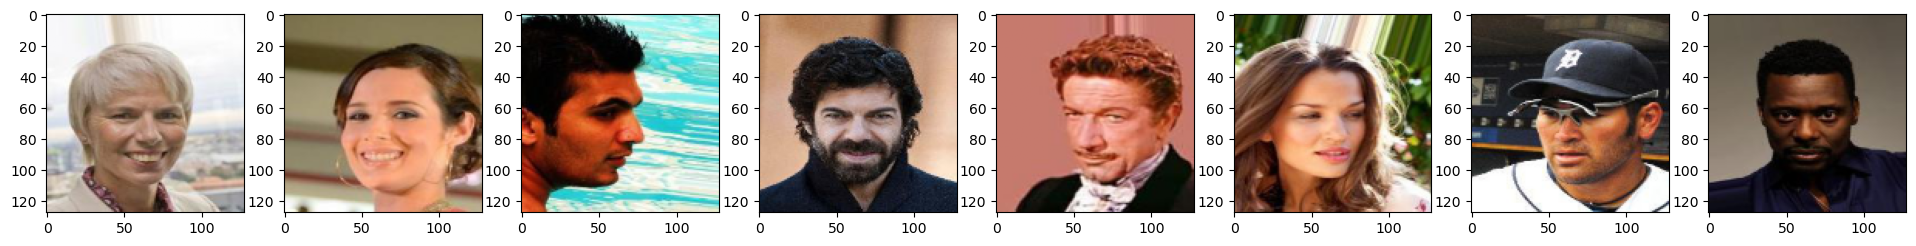

In [34]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,128,128).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()